In [71]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours

In [72]:
'''
Plots the given image

params:
-------
img: image to be plotted.
'''
def show_image(img):
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    plt.axis("off")
    plt.show()


In [73]:
'''
Thresholds the given image and returns the thresholded image

params:
-------
img: image to be thresholded.

return:
------
thresh: thresholded image.

'''
def threshold_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh = cv2.medianBlur(thresh, 5)
    thresh = cv2.medianBlur(thresh, 5)
    thresh = cv2.erode(thresh, None, iterations=1)

    return thresh

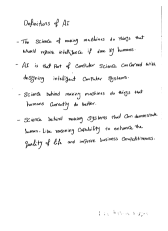

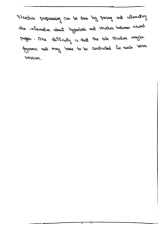

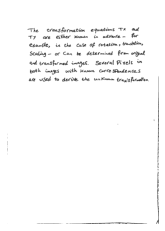

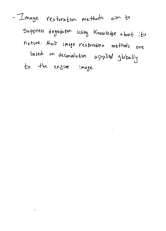

In [74]:
for filename in os.listdir("data/"):
    if filename.endswith(".jpg"):
        img = cv2.imread("data/" + filename)
        thresh = threshold_image(img)
        show_image(thresh)

In [75]:
'''
Crops the text area from the given image

params:
-------
thresh_img: thresholded image to be cropped.

return:
------
cropped_img: binary image cropped on the text area.

'''
def extract_textarea(thresh_img):
    # Kernel for morphological operations
    kernel = np.ones((70, 30), np.uint8)

    # Copy the thresholded image
    binary_img = thresh_img.copy()

    # Erosion and dilation for 3 times to connect the text areas
    binary_img = cv2.erode(binary_img, kernel, iterations=3)
    binary_img = cv2.dilate(binary_img, kernel, iterations=3)
    
    contours = find_contours(binary_img, 1.0)

    bounding_boxes = []
    areas = np.array([])

    # Get the bounding boxes and areas of the text areas
    for contour in contours:
        x_values = contour[:, 1]
        y_values = contour[:, 0]

        Xmin = x_values.min()
        Xmax = x_values.max()

        Ymin = y_values.min()
        Ymax = y_values.max()

        area = (Xmax - Xmin) * (Ymax - Ymin)
        areas = np.append(areas, area)

        bounding_boxes.append([int(np.round(Xmin)), int(np.round(Xmax)), int(np.round(Ymin)), int(np.round(Ymax))])

    # Get the bounding box with the maximum area
    max_area_index = np.argmax(areas)

    # Get the bounding box
    [Xmin, Xmax, Ymin, Ymax] = bounding_boxes[max_area_index]
    
    # Remove the borders of the paper if they are included in the bounding box
    border_length = 40
    Xmin = Xmin + border_length if Xmin in range(border_length) else Xmin
    Xmax = Xmax - border_length if Xmax in range(thresh_img.shape[1] - border_length, thresh_img.shape[1]) else Xmax

    Ymin = Ymin + border_length if Ymin in range(border_length) else Ymin
    Ymax = Ymax - border_length if Ymax in range(thresh_img.shape[0] - border_length, thresh_img.shape[0]) else Ymax

    
    # Create some padding around the text area
    padding = 10
    Ymin = Ymin - padding if Ymin - padding > 0 else 0
    Ymax = Ymax + padding if Ymax + padding < thresh_img.shape[0] else thresh_img.shape[0]
    Xmin = Xmin - padding if Xmin - padding > 0 else 0
    Xmax = Xmax + padding if Xmax + padding < thresh_img.shape[1] else thresh_img.shape[1]

    # Crop the image to get the text area
    cropped_img = thresh_img[Ymin : Ymax, Xmin:Xmax]
    
    return cropped_img

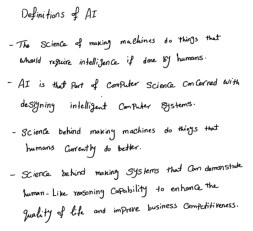

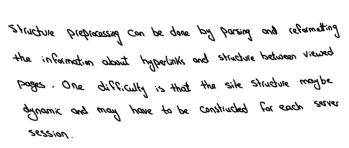

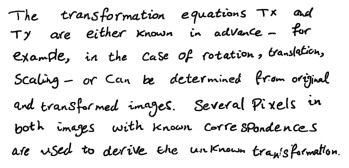

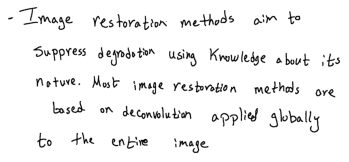

In [77]:
for filename in os.listdir("data/"):
    if filename.endswith(".jpg"):
        img = cv2.imread("data/" + filename)
        thresh = threshold_image(img)
        textarea = extract_textarea(thresh)
        show_image(textarea)
        cv2.imwrite("data/output/" + filename, textarea)